In [54]:
# Basic setup
import numpy as np
import math
import os
np.random.seed(33140)
# we no longer need GPU access this time.

# import plot-related libraries
import matplotlib.pyplot as plt

# Task: clustering MNIST handwritten digits with K-means
This programming assignment requires you to define a K-means model, fit it to handwritten digit images and evaluate the performance. The dataset we employ here is the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset, which consists of handwritten digits of resolution 28 * 28 and their corresponding labels.

The code block below loads the dataset and visualizes some statistics. Note that in this task we only deal with the test subset of MNIST images due to its smaller size (only 10000 images in total).

In [55]:
# download MNIST test data
!wget http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz
!wget http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz

'wget' is not recognized as an internal or external command,
operable program or batch file.
'wget' is not recognized as an internal or external command,
operable program or batch file.


In [56]:
def load_mnist_data():
    # adapted from https://stackoverflow.com/a/53181925
    images_file = 't10k-images-idx3-ubyte.gz'
    labels_file = 't10k-labels-idx1-ubyte.gz'
    import gzip
    with gzip.open(images_file, 'rb') as f:
        images = np.frombuffer(f.read(), np.uint8, offset=16)
    with gzip.open(labels_file, 'rb') as f:
        labels = np.frombuffer(f.read(), np.uint8, offset=8)

    
    # reshape 28x28 images to 10000 flatten vectors, so that the resulting data 
    # has shape [10000, 784], where each row represents a data point. We 
    # convert values to float numbers for ease of computations.
    images = images.reshape(-1, 28 * 28).astype(np.float32)


    return images, labels

Images have shape : (10000, 784), Labels have shape : (10000,)
Maximum pixel values : 255.0, minimum pixel values : 0.0


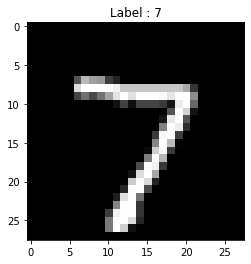

In [57]:
# load mnist data.
images, labels = load_mnist_data()

# print some stats
print("Images have shape : {}, Labels have shape : {}".format(images.shape, labels.shape))
print("Maximum pixel values : {}, minimum pixel values : {}".format(np.amax(images), np.amin(images)))

# plot some digits
_image = images[0]
_label = labels[0]
plt.imshow(_image.reshape(28, 28), cmap='gray')
plt.title("Label : {}".format(_label))
plt.show()

## Task 1: One-hot encodings (10 points). 
In this task, we convert integer-valued labels to its **one-hot encodings**. Suppose the total number of classes is $C$. The one-hot representation of some label with value $c$ is a $C$-dimensional vector, whose entries are all 0 except for the $c$-th element. 

It is called one-hot since intuitively it turns “on” the $c$-th element of the vector, and leaves the other elements “off” (Page 174, [Textbook](https://probml.github.io/pml-book/book1.html)).

    Example: If the total number of classes is 10 (ranging from 0 to 9), then each one-hot vector is 10-dimensional.
    class 0  -> [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    class 1  -> [0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
    class 9  -> [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]

**Question**: 
1. Implement two functions `label_to_onehot()` and `onehot_to_label()`, where the first function transforms an array of labels to a matrix of one-hot encodings, and the second function does the reverse.


In [58]:
def label_to_onehot(labels):
    """
    Convert integer-valued labels to one-hot encodings.
    You can assume the total number of classes C = 10.

    labels: labels.shape == [N], where N is the number of data points.

    return
    onehot_vectors: 
        with shape [N, C], with each row represents 
        a one-hot vector of the corresponding label.
    """
    #### Your code starts here #####
  
    onehot = np.zeros((labels.size,10))
    onehot[np.arange(labels.size),labels.astype(int)] = 1
    return onehot

    #### Your code ends here #####


def onehot_to_label(onehot_vectors):
    """
    Convert one-hot encodings to integer-valued labels.

    onehot_vectors: 
        with shape [N, C], with each row represents 
        a one-hot vector of the corresponding label.

    return
    labels: labels.shape == [N], where N is the number of data points.
    """
    #### Your code starts here #####
    
    def onehot_to_label2(onehot):
        return onehot.argmax(axis=0).item()
    
    return np.apply_along_axis(onehot_to_label2,1,onehot_vectors)
        
    #### Your code ends here #####

In [59]:
# you can check the correctness by simply invoking
# np.allclose() functions compares two nd arrays in an element-wise way.

assert np.allclose(labels, onehot_to_label(label_to_onehot(labels)))


In [60]:
# we need to transform the whole label set to its one-hot 
# encodings for ease of subsequent computations.

labels = label_to_onehot(labels)

## Task 2: K-means (60 points)

In this task, you will implement a workable K-means clustering model to cluster MNIST handwritten digit images. K-means is a popular method to cluster (or partition) a set of $N$ data points into $K$ clusters, so that each data point belongs to the cluster with the nearest cluster center (or called **centroids**).

Technically, let us denote the $K$ clusters as $\boldsymbol{\mu}_1,\dots,\boldsymbol{\mu}_K \in \mathbb{R}^D$, the set of $N$ datapoints as $\boldsymbol{x}_1, \boldsymbol{x}_2, \dots, \boldsymbol{x}_N \in \mathbb{R}^D$. To cluster the data such that each data point is assigned to its closest centroid, the algorithm proceeds as follows:
1. Randomly initialize the cluster centroids $\boldsymbol{\mu}_k$ for each $k=1,2,\dots,K$;
2. For each data point $\boldsymbol{x}_n$ with $n = 1,2,\dots,N$, compute the index $z_n$ of its closest centroid,
$$z_{n}=\arg \min _{k}\left\|\boldsymbol{x}_{n}-\boldsymbol{\mu}_{k}\right\|_{2}^{2};$$
3. Given the information contained in data points, we compute the new cluster centroids as
$$\boldsymbol{\mu}_{k}^{\text{new}} = \frac{1}{N_{k}} \sum_{n: z_{n}=k} \boldsymbol{x}_{n},$$
where $N_k$ is the number of data points that are assigned to the $k$-th cluster.
4. Compare the old and new cluster centroids and if their difference is small enough (say less than 1e-8), then the algorithm has converged and terminates; otherwise, return to step **2** and iterate over the entire data set. In both cases, update the centroids as
$$\boldsymbol{\mu}_{k}\gets\boldsymbol{\mu}_{k}^{\text{new}}, \quad k = 1,2,\dots,K.$$


**Note**: Sometimes, some cluster $k$ might receive no assigned data points. In this case, we just copy the old centroid value, $\boldsymbol{\mu}_{k}^{\text{new}}\gets \boldsymbol{\mu}_{k}$.

### Task 2.1 Initialization (20 points)
K-means is known to be very sensitive to initializations of cluster centroids; here we discuss three different strategies to perform initializations.
- `random`: initialize cluster centroids as random values at $[0,255]$, which is the minimum and maximum value of our image data respectively;
- `kmeans`: pick $K$ data points from the data set at random, and use these as the initial values for $\{\boldsymbol{\mu}_{k}\}_{k=1}^K$.
- `kmeans++` approach: the main idea of `K-means++` is to select cluster centroids **sequentially** to try to cover the data as much as possible. It proceeds as follows (See our lecture [slide](https://nlp.cs.hku.hk/comp3314/14.pdf) or Textbook (Section 21.3.4) for more details):
    - first pick one random data point uniformly to initialize the first centroid;
    - for the remaining centroids, we want them to be as far away as possible from previous centroids. To this end, we also pick data points randomly, but from a weighted probability distribution. 
Assuming $k-1$ centroids have been initialized, for the $k$-th centroid we have 
$$
p\left(\boldsymbol{\mu}_{k}=\boldsymbol{x}_{n}\right)=\frac{D_{k-1}\left(\boldsymbol{x}_{n}\right)}{\sum_{n^{\prime}=1}^{N} D_{k-1}\left(\boldsymbol{x}_{n^{\prime}}\right)}
$$
where
$$D_{k-1}(\boldsymbol{x})=\min _{t=1}^{k-1}\left\|\boldsymbol{x}-\boldsymbol{\mu}_{t}\right\|_{2}^{2}.$$
Intuitively, the probability for the $n$-th data point $\boldsymbol{x}_{n}$ to be chosen as the $k$-th centroid is proportional to its squared distance to the point’s current closest cluster centroid. If $\boldsymbol{x}_{n}$ is far away from all previous centroids, then it would have high probability to be selected; and vice versa. We repeat this process for $k = 2,3,\dots,K$ to construct all centroids.

**Questions**:
1. Implement these 3 strategies in the `init_centroids()` member function, where
    - 5 points for `random`, 
    - 5 points for `kmeans`, and 
    - 10 points for `kmeans++`. 

**Hint**: check the [numpy.random.choice](https://numpy.org/doc/stable/reference/random/generated/numpy.random.choice.html#numpy-random-choice) function.

### Task 2.2 Implement K-means iteration step (20 points)

Suppose the centroids have been initialized. Given a set of data $\boldsymbol{x}_1, \boldsymbol{x}_2, \dots, \boldsymbol{x}_N \in \mathbb{R}^D$,

**Questions**:
1. (20 points) Implement the K-means algorithm (only **step 2 and 3**; step 4 and 5 have been implemented for you) in the `fit()` member function below.

### Task 2.3 Evaluation metrics (20 points)

There are various ways to evaluate whether a clustering algorithm is good or not. In this assignment, we consider two metrics:
- **Purity** measures the extent to which clusters contain a *single* class. Technically, it is defined as (See our lecture [slide](https://nlp.cs.hku.hk/comp3314/14.pdf) or Textbook (Section 21.1.1) for more details)
$$\text{purity} = \sum_{k=1}^K \frac{N_k}{N}p_k,\quad\quad p_k = \max_c \frac{N_{ck}}{N_k},$$
where 
    - $N$ is the total number of data points, 
    - $N_k$ is the total number of data points in cluster $k$, and
    - $N_{ck}$ is the number of data points in cluster $k$ that belong to class $c$.

- **Distortion** measures how individual data points deviate from their assigned cluster centroids. It is just the mean of the squared distance between each data point and its assigned centroid,
$$J=\frac{1}{N}\sum_{n=1}^{N}\left\|\boldsymbol{x}_{n}-\boldsymbol{\mu}_{z_{n}}\right\|^{2}.$$

**Questions**:
1. (10 points) Compute the purity for the new cluster centroids at each step in the `fit()` member function below.
2. (10 points) Compute the distortion at each step in the `fit()` member function below.

**Note**: you are free to modify other parts of the class object as long as the member function signature remains the same.

In [61]:
class Kmeans(object):
    def __init__(self, num_clusters, cluster_dim, max_iterations=1000, threshold=1e-1):
        super().__init__()
        self.num_clusters = num_clusters
        self.cluster_dim = cluster_dim
        self.max_iterations = max_iterations
        self.threshold = threshold # threshold to check convergence
        self.centroids = None
    

    def init_centroids(self, input_x, method):
        """ Task 2.1
        Initialize k-means centroids.

        input_x: shape == [N, d], where 
            N is the number of data points and 
            d is the dimensionality of each data point.

        method: str. Possible values: ['random', 'kmeans', 'kmeans++']

        the initialized centroids must be stored as self.centroids.
        Let K be the number of clusters. self.centroids must be either 
            (1) a 2D ndarray with shape [K, d], or
            (2) a list of K numpy vectors with shape [d].
        """
        if method == 'random':
            ########## Task 2.1 ############
            #### Your code starts here #####
            
          
            self.centroids = np.random.choice(np.arange(256),(self.num_clusters,self.cluster_dim))

            #### Your code ends here #####
        elif method == 'kmeans':
            ########## Task 2.1 ############
            #### Your code starts here #####
            
            centroids = np.zeros((self.num_clusters,self.cluster_dim))
            centroids_index = np.arange(self.num_clusters)
            
            def get_cluster(x_index,index):
                centroids[index] = input_x[x_index]

            picked_x_cluster = np.random.choice(np.arange(input_x.shape[0]),self.num_clusters,False)
            get_cluster = np.vectorize(get_cluster)
            np.apply_along_axis(get_cluster,0,picked_x_cluster,centroids_index)
            self.centroids = centroids
            
            

            #### Your code ends here #####
        elif method == 'kmeans++':
            ########## Task 2.1 ############
            #### Your code starts here #####
            
            denom = None
            prob_array = np.empty(0)
            centroids = np.empty((0,self.cluster_dim))
            centroids = np.vstack((centroids,input_x[np.random.choice(np.arange(256),1).item()]))
            
            
            f = lambda x: (((centroids - x)**2)).sum(axis=1)
            
            for _ in range(self.num_clusters-1):
                denom = (np.apply_along_axis(f, 1, input_x).min(1)).sum()
                min_array = (np.apply_along_axis(f, 1, input_x).min(1))
                prob_array = min_array/denom
                new_cluster_index = prob_array.argmax(axis = 0).item()
                centroids = np.vstack((centroids,input_x[new_cluster_index]))
            
            self.centroids = centroids
                
            #### Your code ends here #####
        else:
            raise NotImplementedError("method {} is not supported!".format(method))
        
        assert self.centroids is not None
        

    def fit(self, input_x, input_y):
        """ Task 2.2 & 2.3
        Do the K-means clustering step until convergence.

        input_x: shape == [N, d], where 
            N is the number of data points and 
            d is the dimensionality of each data point.

        input_y: shape == [N, C], where
            K is the number of clusters and 
            C is the number of classes.
        
        *Note that input_y are label one-hot encodings.
        *During clustering, we do not use the label information; input_y is passed
        for you to compute the purity of the formed clusters.

        """
        cur_iter = 0
        N = input_y.shape[0]
        C = input_y.shape[1]
        while cur_iter < self.max_iterations:
            ########## Task 2.2 ############
            #### Your code starts here #####

            # step 2.
            
           
            num_data_in_cluster = np.zeros(self.num_clusters)
            total_in_cluster = np.zeros((self.num_clusters,self.cluster_dim))
            
            def check_closest_cluster(x):
                return (((self.centroids - x)**2)).sum(axis=1).argmin()
            
            def calc_cluster_info(cluster_index,index):
                num_data_in_cluster[cluster_index] += 1
                total_in_cluster[cluster_index] = total_in_cluster[cluster_index] + input_x[index]
            
            calc_cluster_info = np.vectorize(calc_cluster_info)
            x_index = np.arange(input_x.shape[0]) 
            index_of_closest_from_data = np.apply_along_axis(check_closest_cluster, 1, input_x)
            np.apply_along_axis(calc_cluster_info,0,index_of_closest_from_data,x_index)
      
            # step 3.
            # the new computed centroid should be named as new_centroids
            
            new_centroids = np.divide(total_in_cluster, num_data_in_cluster[:,np.newaxis], out=np.zeros_like(total_in_cluster), where=num_data_in_cluster[:,np.newaxis]!=0)

            #### Your code ends here #####


            ########## Task 2.3 ############
            #### Your code starts here #####
            
            def calc_purity(cluster_index):
                return input_y[np.where(index_of_closest_from_data==cluster_index)[0]].sum(axis=0).max()/input_x.shape[0]
            def calc_distortion(cluster_index,input_x_index):
                return ((self.centroids[cluster_index]-input_x[input_x_index])**2).sum()
                
            calc_purity = np.vectorize(calc_purity)
            calc_distortion = np.vectorize(calc_distortion)
            input_x_index = np.arange(input_x.shape[0])
            
            # calculate distortion and purity
            
            purity = np.apply_along_axis(calc_purity, 0, np.arange(self.num_clusters)).sum()
            distortion = np.apply_along_axis(calc_distortion, 0, index_of_closest_from_data,input_x_index).sum()/input_x.shape[0]
            

            #### Your code ends here #####

            # 4. check convergence
            print("* Iteration : [{:4d}/{:4d}] o distortion: {:.3f} o purity: {:.3f}".format(
                cur_iter, self.max_iterations, distortion, purity))

            diff = np.mean((new_centroids - self.centroids) ** 2)
            self.centroids = new_centroids
            cur_iter = cur_iter + 1
            if diff < self.threshold:
                print("Converged at {}-th iteration.".format(cur_iter))
                break       

We provide additional functions for ease of visualization.

In [62]:
# this helper function plots a row of figures/images.
def vector_to_image_plots(input_vec, num_figures=1):
    # see the usage below.
    # given data with shape [28 * 28]
    if isinstance(input_vec, list):
        input_vec = np.vstack(input_vec)
    num_vec = input_vec.shape[0]
    assert num_figures == num_vec
    new_shape = (num_figures, 28, 28)
    input_vec = input_vec.reshape(new_shape)
    input_vec = input_vec.astype(np.uint8)

    plt.subplots_adjust(wspace=0.1, hspace=0)
    figs, axes = plt.subplots(nrows=1, ncols=num_figures)
    # figs.tight_layout()
    for n in range(num_figures):
            axes[n].set_axis_off()
            axes[n].imshow(input_vec[n], cmap='gray')
    plt.show()

If you implement K-means model properly, the following fitting script should work smoothly.

**Note**: In general, it is normal if you observe the distortion does not decrease or converges to a very large value; however, the purity (ranging from 0 to 1) should keep increasing and probably converge at around 0.500 ~ 0.700.

Centroids before fitting


<Figure size 432x288 with 0 Axes>

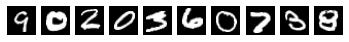

------------------------------------------------------------------------
* Iteration : [   0/ 200] o distortion: 5574216.386 o purity: 0.292
* Iteration : [   1/ 200] o distortion: 2841270.794 o purity: 0.406
* Iteration : [   2/ 200] o distortion: 2725446.062 o purity: 0.436
* Iteration : [   3/ 200] o distortion: 2685402.092 o purity: 0.441
* Iteration : [   4/ 200] o distortion: 2664422.071 o purity: 0.441
* Iteration : [   5/ 200] o distortion: 2643168.912 o purity: 0.445
* Iteration : [   6/ 200] o distortion: 2619522.047 o purity: 0.452
* Iteration : [   7/ 200] o distortion: 2595187.556 o purity: 0.468
* Iteration : [   8/ 200] o distortion: 2578860.388 o purity: 0.488
* Iteration : [   9/ 200] o distortion: 2567772.970 o purity: 0.507
* Iteration : [  10/ 200] o distortion: 2560151.646 o purity: 0.525
* Iteration : [  11/ 200] o distortion: 2554648.859 o purity: 0.541
* Iteration : [  12/ 200] o distortion: 2550128.337 o purity: 0.553
* Iteration : [  13/ 200] o distortion: 254

<Figure size 432x288 with 0 Axes>

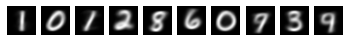

In [63]:
num_centroids = 10
num_classes = 10
cluster_dim = 784
max_iterations = 200
threshold = 1e-5
init_method = 'kmeans++'
# instantiate the KMeans model.
kmeans = Kmeans(num_centroids, cluster_dim, max_iterations, threshold)
# initialize the Kmeans centroids
kmeans.init_centroids(images, init_method)

print("Centroids before fitting")
vector_to_image_plots(kmeans.centroids, num_centroids)

print("------------------------------------------------------------------------")
kmeans.fit(images, labels)
print("------------------------------------------------------------------------")

print("Centroids after fitting")
vector_to_image_plots(kmeans.centroids, num_centroids)

## Task 3: Evaluation (30 points).
In this section, you will evaluate your fitted K-means model at various aspects.

**Questions**:
1. (10 points) Compare the performance of three different initialization strategies in Task 2.1 and explain your findings.
2. (10 points) For `random` initialization strategy, compare the centroid shapes (plotted by `vector_to_image_plots()` function) **before** and **after** fitting. Briefly describe your observations.
3. (10 points) We know the actual number of clusters for our case is 10, since the data comes from 10 classes. Nevertheless, as there exist natural similarities between different digits (e.g., `1` and `7`, `8` and `3`, etc.), try to vary the number of clusters between 3, 10, 15, 20, 100, and 
    1. (5 points) Plot the **distortion** and  **purity** curves versus the number of iterations under different numbers of clusters.
    2. (5 points) Normally, you would observe **distortion** and  **purity** just keeps decreasing and increasing respectively as the number of clusters increases, although the `oracle` is to maintain 10 clusters. Explain why this is the case.
    
    
**Hint**: as pointed out in our textbook, we can trivially achieve a purity of 1 by putting each object into its own cluster; hence these two are generally not a perfect metric for evaluating clustering methods.


Text(0.5, 0, 'cluster')

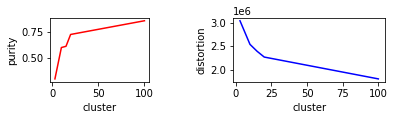

In [64]:
#### Your code starts here #####
# Q3A.

# Recorded purity and distortion

result_purity = np.array([0.299,0.601,0.613,0.727,0.859])
result_distortion = np.array([3039479.356,2536813.850,2389506.054,2266594.501,1801594.254 ])
cluster_size = np.array([3, 10, 15, 20, 100])

plt.subplot(3,3,1)
plt.plot(cluster_size,result_purity,'r')
plt.ylabel("purity")
plt.xlabel("cluster")
plt.subplot(3,2,2)
plt.plot(cluster_size,result_distortion,'b')
plt.ylabel("distortion")
plt.xlabel("cluster")

#### Your code ends here #####

In [65]:
`Your explanation starts here:`

# Q1.

# Since kmeans++ picks the new centroid far away from the existing centroids, it usually requires fewer iterations to find the 
# global optimum compared to random and kmeans

# Another finding was that since random initalization does not pick data points as centroids, there is a chance that a 
# centroid does not get any data points belonging to it. Hence when computing the new centroid in step 3, it returns a 
# division by zero error since Nk = 0. Thus a small change was needed to solve this. Whereas kmeans and kmeans++ are guaranteed
# to have at least one data point (the centroid itself) belonging to it


# Q2.
# Before fitting, the centroid shapes are just black and white pixels without any meaning. After fitting, the centroid 
# shapes start to form digits from 0- 9

# Q3B.
# Distortion decreases and purity increases as number of clusters increase because the chances that each data point have its own
# cluster increases 

---



SyntaxError: invalid syntax (3444719086.py, line 1)